# R4 on Plant Phenotyping Dataset

In [2]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import PlantNet
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import plant

# Get the dataloaders 

In [3]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 50

cuda:1


In [4]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
SPLIT_ROOT = "/vol/bitbucket/mg2720/plant/rgb_dataset_splits"
DATA_ROOT = "/vol/bitbucket/mg2720/plant/rgb_data"
MASKS_FILE = "/vol/bitbucket/mg2720/plant/mask/preprocessed_masks.pyu"

plant_train_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, True)
plant_test_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, False)
print(len(plant_train_2), len(plant_test_2))

1806 604


tensor(1.)


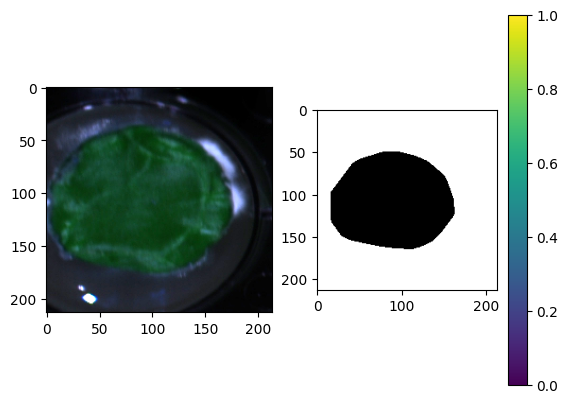

tensor(1.)


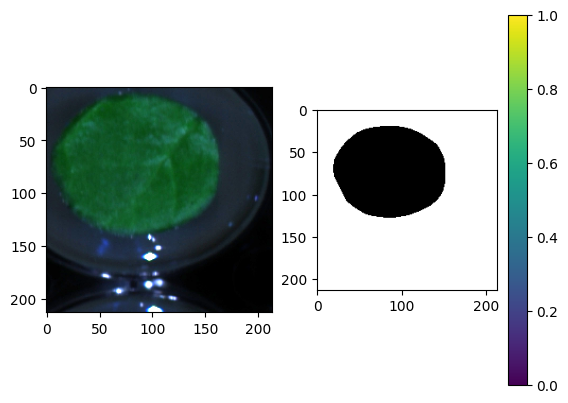

tensor(1.)


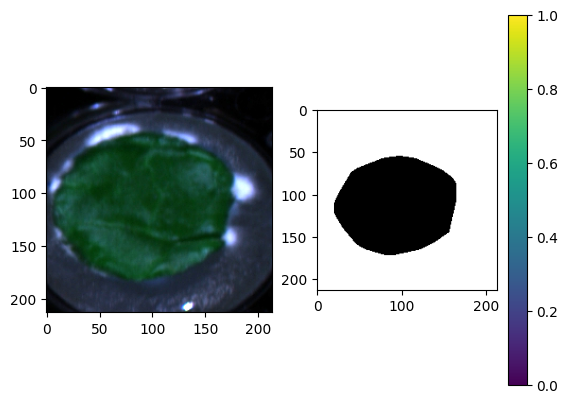

tensor(1.)


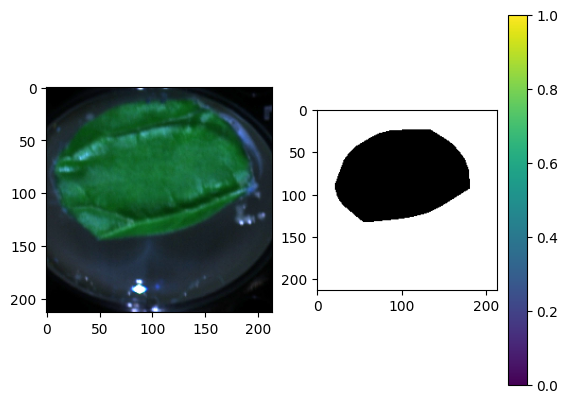

tensor(0.)


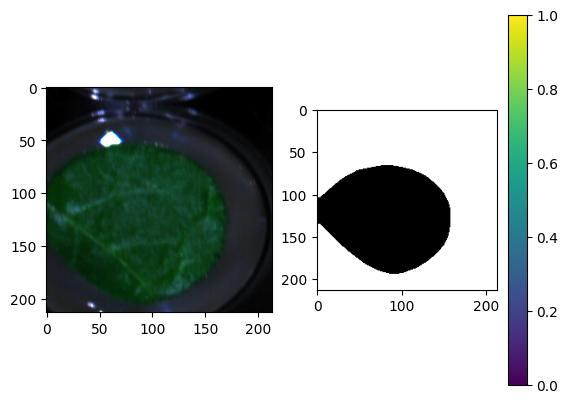

In [5]:
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(plant_train_2), (5,))
for i in rand_5:
    img, img_label, img_mask = plant_train_2[i]
    print(img_label)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0).squeeze().numpy())
    im_mask = ax[1].imshow(img_mask.permute(1, 2, 0).squeeze().numpy())
    fig.colorbar(im_mask, ax=ax[1])
    plt.show()

In [6]:
dl_train = plant.get_dataloader(plant_train_2, batch_size)
dl_test = plant.get_dataloader(plant_test_2, batch_size)

In [7]:
def train_model_with(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k, has_conv):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # pre-train the model
    progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
    for _ in progress_bar:
        for i, (x, u, m) in enumerate(dl_train):
            # Forward pass
            u, x, m = u.to(device).float(), x.to(device), m.to(device)

            # output is [batch_size, 1], u is [bach_size] but BCELoss does not support different target and source sizes
            output = model(x).squeeze()
            # For std, we will waste some time doing the bounds, but at least it is consistent across methods
            inp_grad_reg = input_gradient_interval_regularizer(
                model, x, u, "binary_cross_entropy", epsilon, 0.0, regularizer_type=mlx_method, batch_masks=m, has_conv=has_conv, device=device
            )
            if mlx_method == "std":
                assert inp_grad_reg == 0
            loss = criterion(output, u) + k * inp_grad_reg
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                progress_bar.set_postfix(loss=loss.item())

In [8]:
def test_model_acc(model):
    # evaluate the pre-trained model
    # here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
    all_acc = 0
    for test_batch, test_labels, _ in dl_test:
        # Just do a simple forward and compare the output to the labels
        test_batch, test_labels = test_batch.to(device), test_labels.to(device)
        output = model(test_batch).squeeze()
        correct = ((output > 0.5) == (test_labels)).sum().item()
        all_acc += correct
    all_acc /= len(dl_test.dataset)
    print("--- Pre-trained model accuracy ---")
    print(f"Nominal = {all_acc:.2g}")

In [9]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv):
    channel_to_view = 1
    batch_input, batch_labels, batch_mask = batch_input.to(device), batch_labels.to(device), batch_mask.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask, has_conv=has_conv
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].permute(1, 2, 0).cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    cbu = fig.colorbar(im_dx_u, ax=ax[1][1])
    cbu.ax.invert_yaxis()
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [10]:
# define model, dataset and optimizer
num_epochs = 5
lr = 0.001
restarts = 1
epsilon = 0.01
# k is a coefficient for the regularization term
k = 0.2
model = PlantNet(3, 1)
criterion = torch.nn.BCELoss()
gpu_ids = [i for i in range(torch.cuda.device_count())]
print(gpu_ids)
model = torch.nn.DataParallel(model, device_ids=gpu_ids)
model = model.to(device)

[0, 1]


44
Batch input shape: torch.Size([50, 3, 213, 213]), batch mask shape: torch.Size([50, 3, 213, 213])
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


AttributeError: 'Colorbar' object has no attribute 'invert_yaxis'

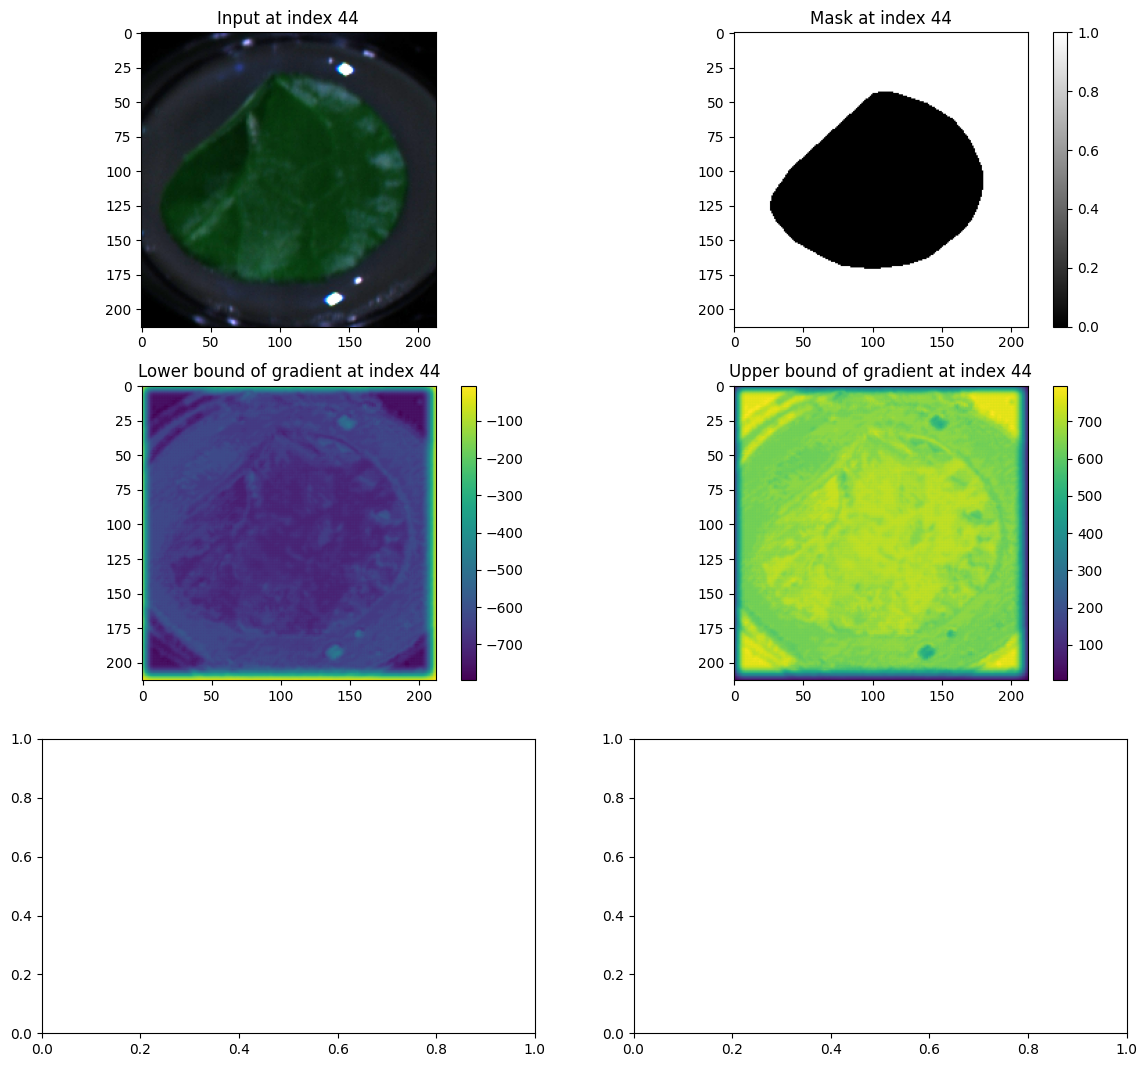

In [11]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
print(idx_to_visualize)
init_batch_train_with_masks = next(iter(dl_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

## Experiments 

### Standard Training

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 5/5 [01:36<00:00, 19.30s/it, loss=0.423]


--- Pre-trained model accuracy ---
Nominal = 0.87
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


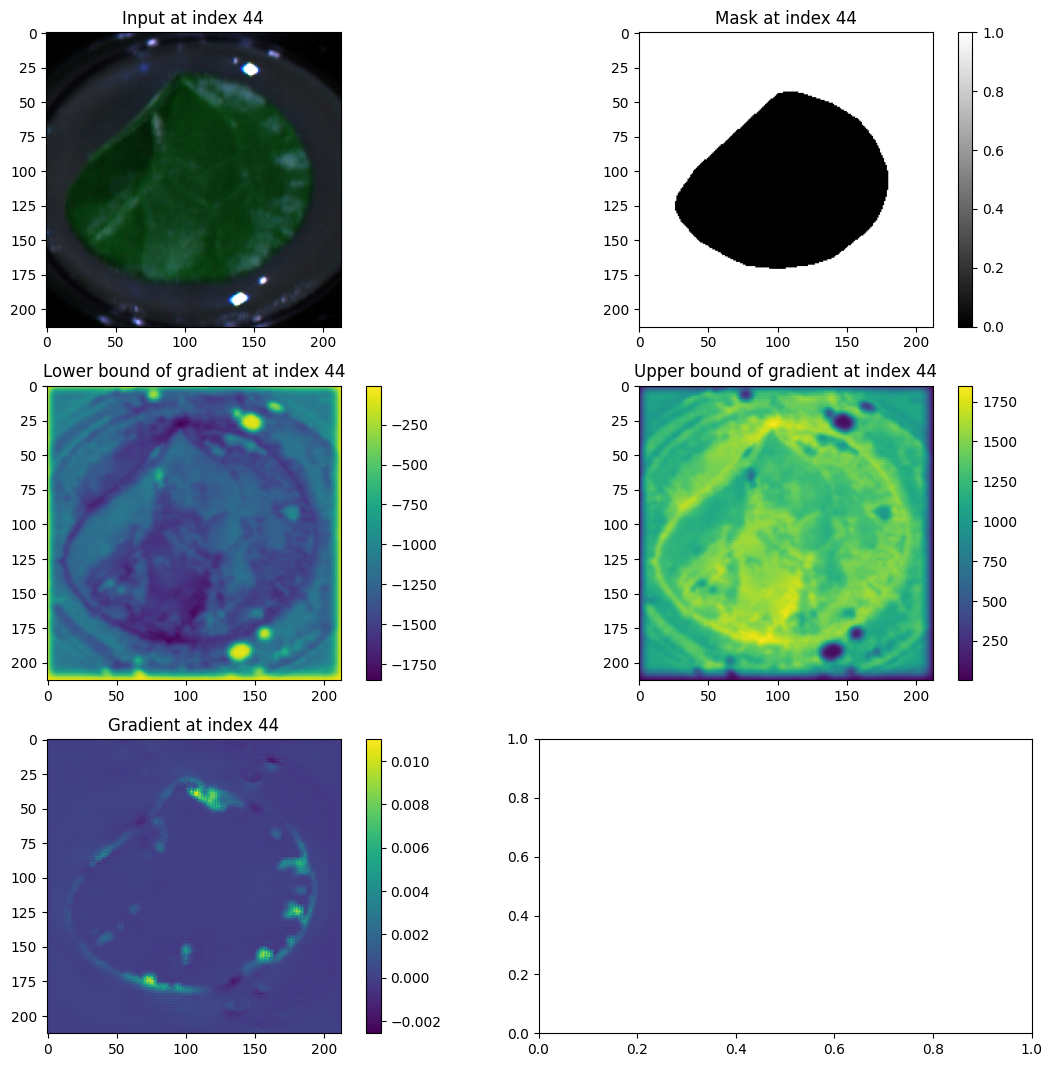

In [17]:
mlx_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1).to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k, has_conv=True)
    test_model_acc(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 5/5 [03:35<00:00, 43.00s/it, loss=0.545]


--- Pre-trained model accuracy ---
Nominal = 0.86
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


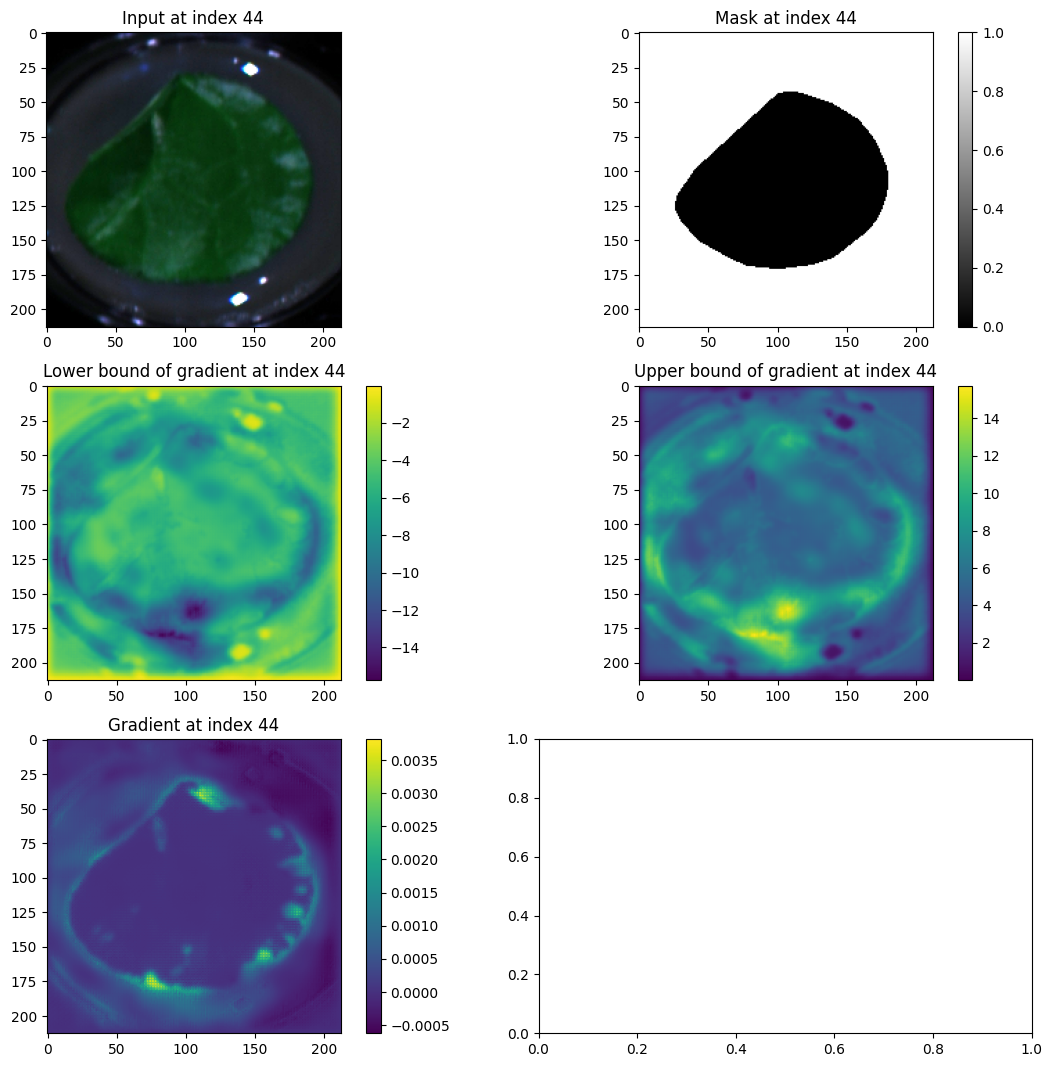

In [11]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1).to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, 1e-2, has_conv=True)
    test_model_acc(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

In [15]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1).to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, has_conv=True)
    test_model_acc(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

========== Training model with method R4, restart 0 ==========


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 278.00 MiB. GPU 1 has a total capacity of 44.32 GiB of which 241.31 MiB is free. Including non-PyTorch memory, this process has 44.08 GiB memory in use. Of the allocated memory 42.61 GiB is allocated by PyTorch, and 974.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)